In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils

In [35]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=50)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr_g", type=float, default=1e-4)
parser.add_argument("--lr_d", type=float, default=4e-4)
parser.add_argument("--nch_g", type=int, default=64)
parser.add_argument("--nch_d", type=int, default=64)
parser.add_argument("--z_dim", type=int, default=100) # noize dimension
parser.add_argument("--beta1", type=float, default=0.0) # for Adam optimizer
opt = parser.parse_args(args=[])

In [36]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels // 8
        self.fx_1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.gx_1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.hx_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-2)

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H * W).permute(0, 2, 1) # 転置
        gx = self.gx_1x1(x).view(B, -1, H * W)
        hx = self.hx_1x1(x).view(B, -1, H * W)
        s_mtx = torch.bmm(fx, gx)   # ミニバッチ毎に行列積を計算
        attention = self.softmax(s_mtx)
        o = torch.bmm(hx, attention)    # attention で重み付けられた入力が返ってくる
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [37]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/data/102flowers/jpg/*.jpg")
        self.transform = transform
    
    def __getitem__(self, index):
        # If transform exists, do pre_process
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)


In [38]:
class Generator(nn.Module):
    def __init__(self, self_attention, z_dim=100, ngf=64, nc=3):   # nc=1 for black-and-white images
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4, 1, 0, True)
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1, True)
        self.convt3 = self.conv_trans_layers(4*ngf, 2*ngf, 4, 2, 1, True)
        self.attention1 = self_attention(2 * ngf)
        self.convt4 = self.conv_trans_layers(2*ngf, ngf, 4, 2, 1, True)
        self.attention2 = self_attention(ngf)
        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.attention1(out)
        out = self.convt4(out)
        out = self.attention2(out)
        out = self.convt5(out)
        return out


In [39]:
class Discriminator(nn.Module):
    def __init__(self, self_attention, nc=3, ndf=64):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.conv2 = self.conv_layers(ndf, 2*ndf)
        self.conv3 = self.conv_layers(2*ndf, 4*ndf)
        self.attention1 = self_attention(4 * ndf)
        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.attention2 = self_attention(8 * ndf)
        self.conv5 = nn.Conv2d(8 * ndf, 1, 4)

    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=2,
                    has_batch_norm=False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.1, inplace=True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.attention1(out)
        out = self.conv4(out)
        out = self.attention2(out)
        out = self.conv5(out)
        return out


In [40]:
def weights_init(m):
    # m means model
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)   # initialize using normal distribution
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   # initialize using normal distribution
        nn.init.constant_(m.bias.data, 0)   # initialize


In [41]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [42]:
import os

In [43]:
dir_path = "/content/drive/MyDrive/result"
os.makedirs(dir_path, exist_ok=True)

In [44]:
# dataset = dset.MNIST(root="/content/drive/MyDrive/data/", download=False,
#                      train=True, transform=transform)
dataset = ImageDataset(transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
netG = Generator(SelfAttention, z_dim=opt.z_dim, ngf=opt.nch_g).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(SelfAttention, nc=3, ndf=opt.nch_d).to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (attention1): SelfAttention(
    (fx_1x1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (gx_1x1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (hx_1x1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-2)
  )
  (convt4): Sequential(
    (0): ConvTranspose2

In [47]:
# criterion = nn.BCELoss()


optimizerG = optim.Adam(netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, 0.999), weight_decay=1e-5)
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, 0.999), weight_decay=1e-5)

In [48]:
def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + "/g_{:04d}.pth".format(epoch)
    )
    torch.save(
        netD.state_dict(),
        file_path + "/d_{:04d}.pth".format(epoch)
    )


In [49]:
model_name = "SAGAN"
f_path_result = "/content/drive/MyDrive/result/{}".format(model_name)
f_path_params = "/content/drive/MyDrive/params/{}".format(model_name)

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)

100%|██████████| 128/128 [03:25<00:00,  1.60s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, lossD: 0.3438855252952635, lossG: 1.5373148215003312


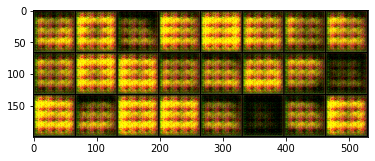

100%|██████████| 128/128 [01:14<00:00,  1.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, lossD: 0.23884433301282115, lossG: 1.2974659111350775


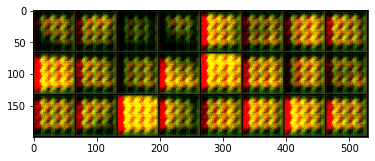

100%|██████████| 128/128 [01:14<00:00,  1.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2, lossD: 0.24819310285965912, lossG: 1.300993625074625


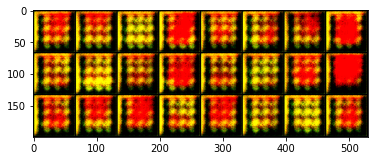

100%|██████████| 128/128 [01:15<00:00,  1.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3, lossD: 0.32841622323030606, lossG: 1.1624454953707755


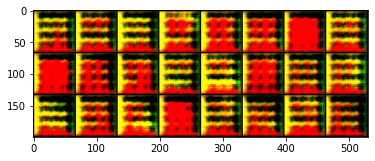

100%|██████████| 128/128 [01:14<00:00,  1.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4, lossD: 0.4801171460421756, lossG: 1.1604279479943216


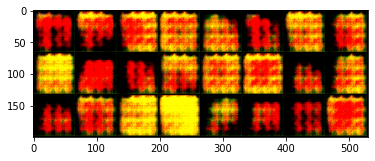

100%|██████████| 128/128 [01:14<00:00,  1.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 5, lossD: 1.2527973473188467, lossG: 0.8127088997280225


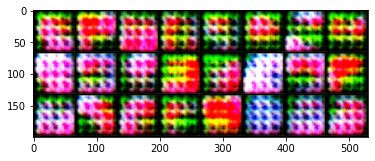

100%|██████████| 128/128 [01:14<00:00,  1.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 6, lossD: 1.883012087084353, lossG: 0.49530615096591646


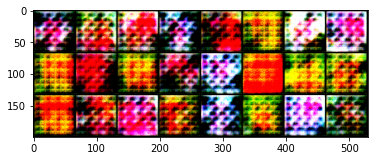

100%|██████████| 128/128 [01:14<00:00,  1.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 7, lossD: 1.899369165301323, lossG: 0.37977297353063477


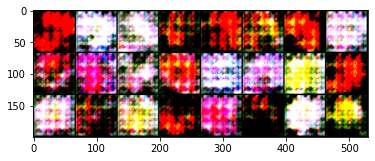

100%|██████████| 128/128 [01:15<00:00,  1.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 8, lossD: 1.9087339863181114, lossG: 0.4100683300057426


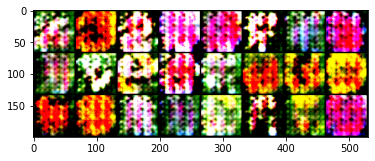

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 9, lossD: 1.874243221245706, lossG: 0.40488646952508134


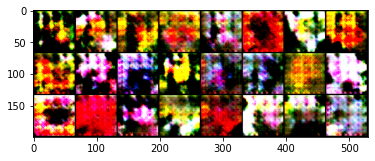

100%|██████████| 128/128 [01:15<00:00,  1.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 10, lossD: 1.828783480450511, lossG: 0.4689017029304523


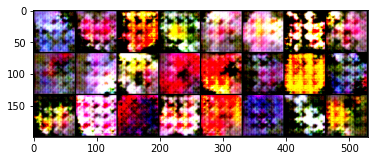

100%|██████████| 128/128 [01:14<00:00,  1.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 11, lossD: 1.8048337204381824, lossG: 0.5435593609581701


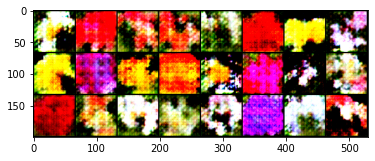

100%|██████████| 128/128 [01:14<00:00,  1.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 12, lossD: 1.769526126794517, lossG: 0.5018633973668329


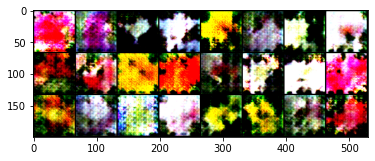

100%|██████████| 128/128 [01:15<00:00,  1.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 13, lossD: 1.7623567515984178, lossG: 0.526583612212562


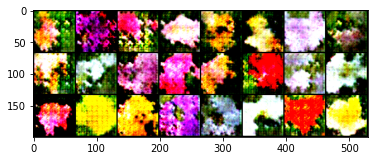

100%|██████████| 128/128 [01:15<00:00,  1.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 14, lossD: 1.7428408423438668, lossG: 0.5736557481286582


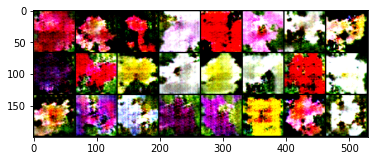

100%|██████████| 128/128 [01:15<00:00,  1.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 15, lossD: 1.6952786529436707, lossG: 0.6023052826494677


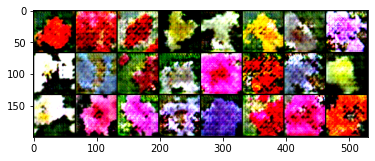

100%|██████████| 128/128 [01:15<00:00,  1.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 16, lossD: 1.603331289254129, lossG: 0.7307654509058921


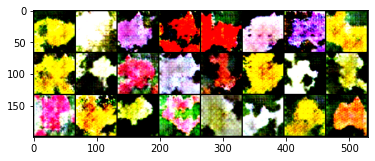

100%|██████████| 128/128 [01:15<00:00,  1.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 17, lossD: 1.50128960236907, lossG: 0.8435052691202145


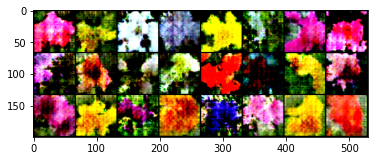

100%|██████████| 128/128 [01:15<00:00,  1.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 18, lossD: 1.420097867026925, lossG: 0.8907901081256568


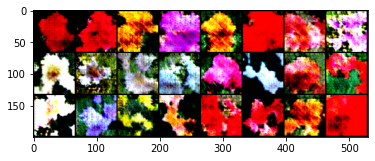

100%|██████████| 128/128 [01:15<00:00,  1.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 19, lossD: 1.3335222522728145, lossG: 0.9562062848417554


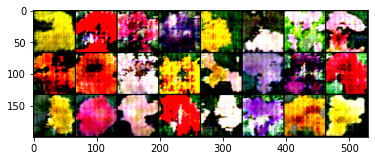

100%|██████████| 128/128 [01:15<00:00,  1.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20, lossD: 1.2211882881820202, lossG: 1.057287401665235


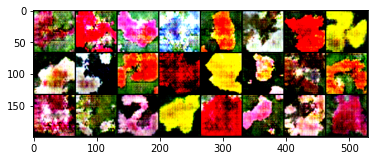

100%|██████████| 128/128 [01:15<00:00,  1.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 21, lossD: 1.151428772136569, lossG: 1.1031507221341599


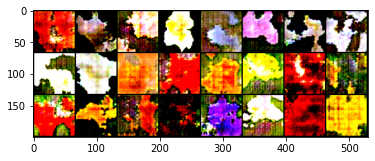

100%|██████████| 128/128 [01:15<00:00,  1.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 22, lossD: 1.0474540735594928, lossG: 1.2455567771103233


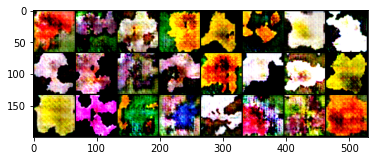

100%|██████████| 128/128 [01:16<00:00,  1.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 23, lossD: 0.9726658063009381, lossG: 1.299508879717905


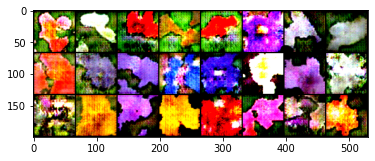

100%|██████████| 128/128 [01:16<00:00,  1.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 24, lossD: 0.901129629695788, lossG: 1.3909949771186803


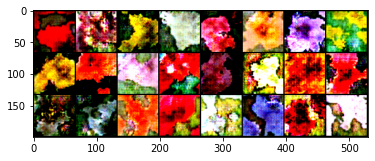

100%|██████████| 128/128 [01:15<00:00,  1.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 25, lossD: 0.8447565499227494, lossG: 1.494838889571838


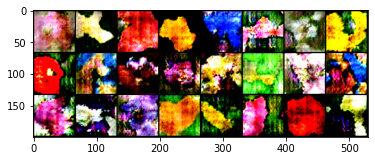

100%|██████████| 128/128 [01:15<00:00,  1.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 26, lossD: 0.8534038360230625, lossG: 1.5062739322893322


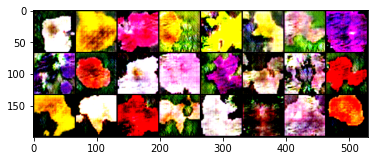

100%|██████████| 128/128 [01:15<00:00,  1.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 27, lossD: 0.7987338183447719, lossG: 1.570209743338637


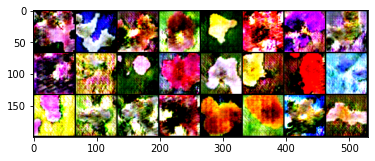

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 28, lossD: 0.7562359059229493, lossG: 1.6641190075315535


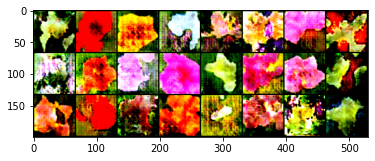

100%|██████████| 128/128 [01:16<00:00,  1.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 29, lossD: 0.7087704862933606, lossG: 1.772421105648391


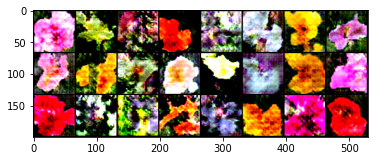

100%|██████████| 128/128 [01:16<00:00,  1.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 30, lossD: 0.6440099424216896, lossG: 1.8447372452355921


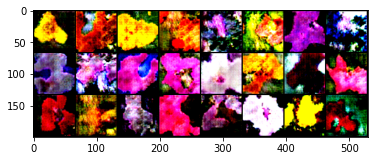

100%|██████████| 128/128 [01:16<00:00,  1.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 31, lossD: 0.6312102247029543, lossG: 1.886116508860141


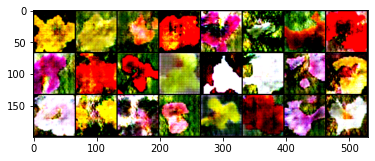

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 32, lossD: 0.590424191323109, lossG: 1.9698811112903059


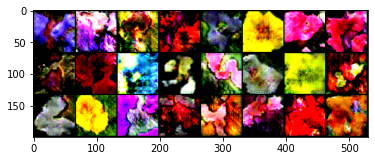

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 33, lossD: 0.56032688182313, lossG: 1.9929138200823218


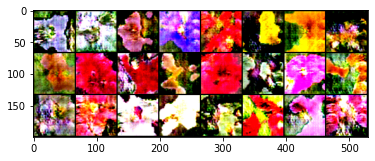

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 34, lossD: 0.5006724275881425, lossG: 2.090980288106948


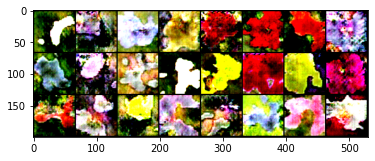

100%|██████████| 128/128 [01:17<00:00,  1.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 35, lossD: 0.522897383198142, lossG: 2.0710014583310112


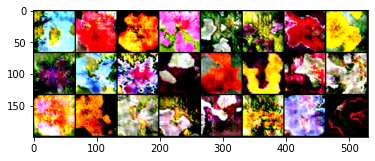

100%|██████████| 128/128 [01:17<00:00,  1.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 36, lossD: 0.4731115804752335, lossG: 2.2096170897129923


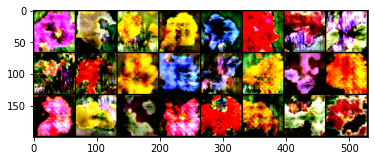

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 37, lossD: 0.4539969755569473, lossG: 2.3005964998155832


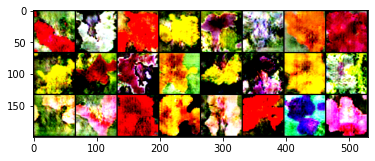

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 38, lossD: 0.4108663636725396, lossG: 2.335281956475228


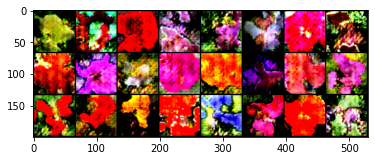

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 39, lossD: 0.4038490841630846, lossG: 2.3733145422302186


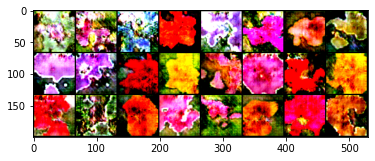

100%|██████████| 128/128 [01:17<00:00,  1.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 40, lossD: 0.38123643083963543, lossG: 2.46621899260208


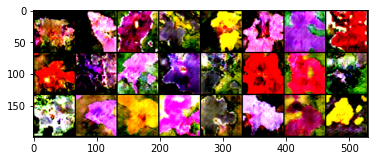

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 41, lossD: 0.3345609932439402, lossG: 2.4749478241428733


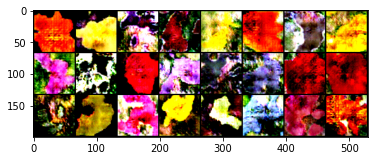

100%|██████████| 128/128 [01:17<00:00,  1.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 42, lossD: 0.4097721077268943, lossG: 2.3095630805473775


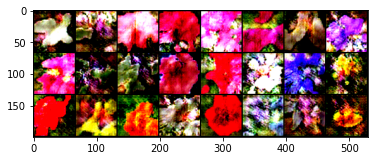

100%|██████████| 128/128 [01:17<00:00,  1.65it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 43, lossD: 0.3462135816225782, lossG: 2.5903557841666043


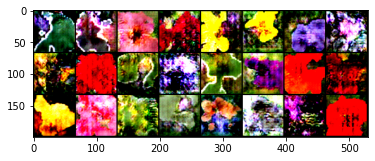

100%|██████████| 128/128 [01:17<00:00,  1.65it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 44, lossD: 0.29282979713752866, lossG: 2.706972730346024


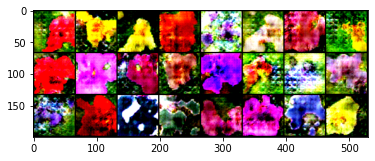

100%|██████████| 128/128 [01:17<00:00,  1.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 45, lossD: 0.35390746977645904, lossG: 2.6947938387747854


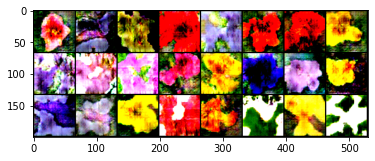

100%|██████████| 128/128 [01:17<00:00,  1.65it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 46, lossD: 0.33199551759753376, lossG: 2.567651240620762


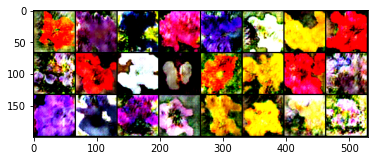

100%|██████████| 128/128 [01:17<00:00,  1.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 47, lossD: 0.27899606816936284, lossG: 2.74000292038545


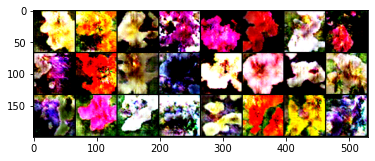

100%|██████████| 128/128 [01:17<00:00,  1.65it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 48, lossD: 0.33618715523334686, lossG: 2.723897172603756


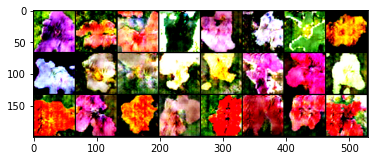

100%|██████████| 128/128 [01:17<00:00,  1.65it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 49, lossD: 0.311484505305998, lossG: 2.739684697939083


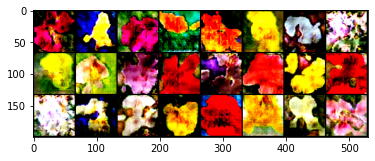

In [50]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []
relu = torch.nn.ReLU()
for epoch in range(opt.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, real_imgs in enumerate(tqdm.tqdm(dataloader, position=0)):
        real_imgs = real_imgs.to(device)    # GPU 上に写真を送る
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #
        # Train Disc
        #
        netD.zero_grad()
        output = netD(real_imgs)
        # lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output))

        fake_imgs = netG(noise)
        output = netD(fake_imgs.detach())   # 識別器の訓練の際には、生成器の方は更新しないので、detach
        # lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output))

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        #
        # Train Gen
        #
        netG.zero_grad()
        output = netD(fake_imgs)
        # lossG = criterion(output, labels_real)  # real を渡すのがポイント、生成器は騙したいので！fakeが真
        lossG = -torch.mean(output)
        lossG.backward()
        optimizerG.step()

        #
        # save losses
        #
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())
    
    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    print("epoch: {}, lossD: {}, lossG: {}".format(epoch, running_lossD, running_lossG))
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    # show fake imgs
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach() + 0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1, 2, 0)))
    plt.show()

    # save imgs and params
    vutils.save_image(fake_imgs + 0.5, f_path_result + "/{:04d}.jpg".format(epoch))
    save_params(f_path_params, epoch, netD, netG)


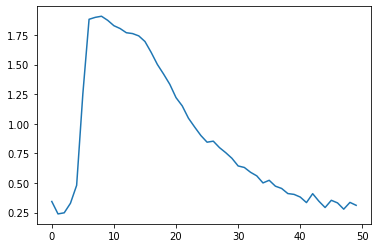

In [51]:
plt.plot(lossesD)

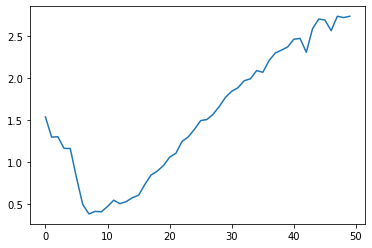

In [52]:
plt.plot(lossesG)